### Imports

In [1]:
import numpy as np
from specmf.models import Graph, MultiFidelityModel
from specmf.utils import error_analysis, val_test_split
from specmf.data import load_data
from specmf.plot import *

In [2]:
%%html
<style type='text/css'>
.CodeMirror{
font-size: 14px;
</style>

In [24]:
X = np.random.rand(200, 2)
n_LF = X.shape[0]
n_HF = 5
inds_train = np.random.choice(n_LF, n_HF, replace = False).tolist()

g = Graph(X, corr_scale = 0.05)
W = g.adjacency
L = g.graph_laplacian
eigvals, eigvecs = g.laplacian_eig()

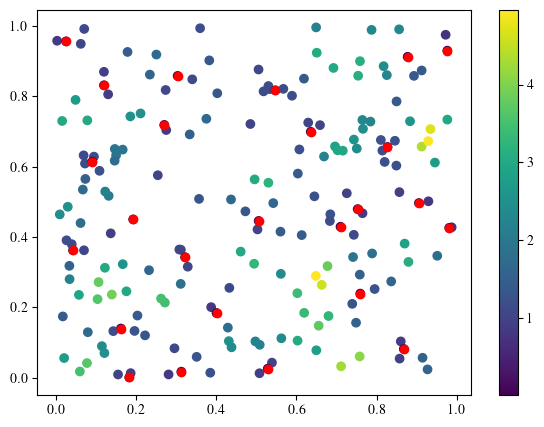

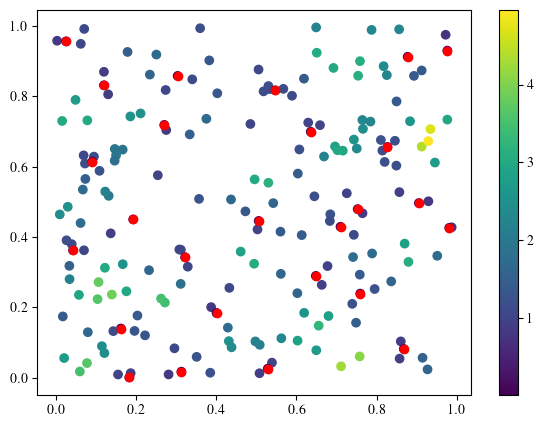

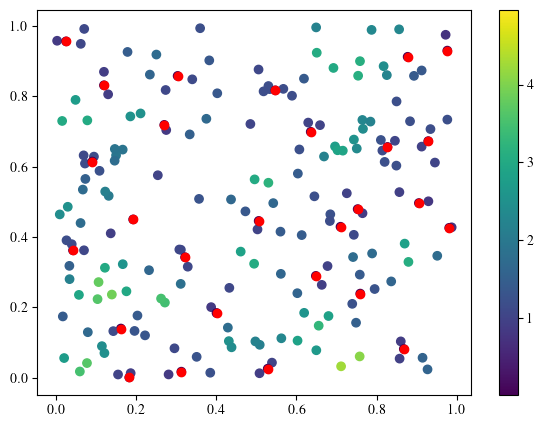

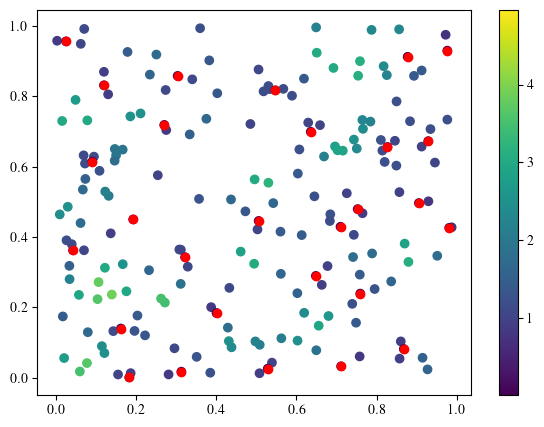

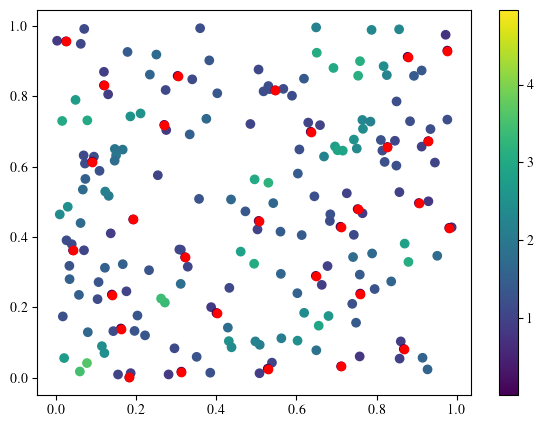

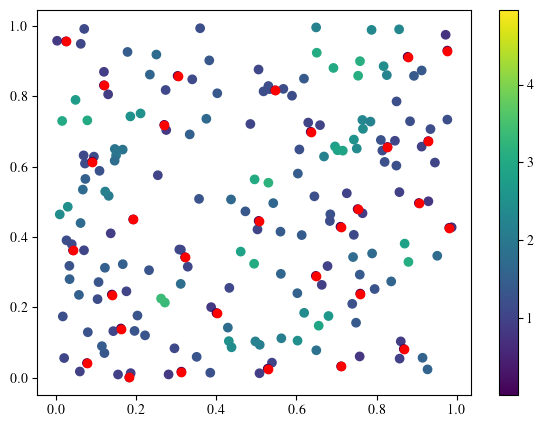

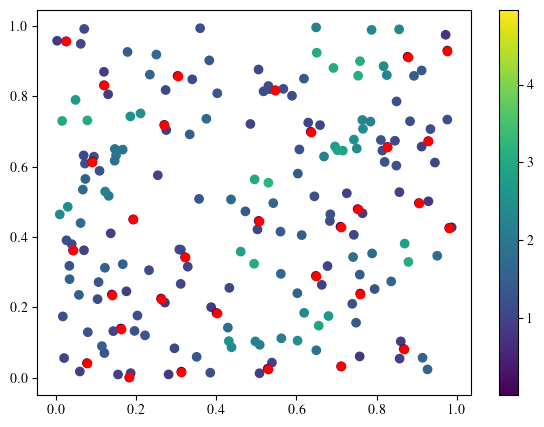

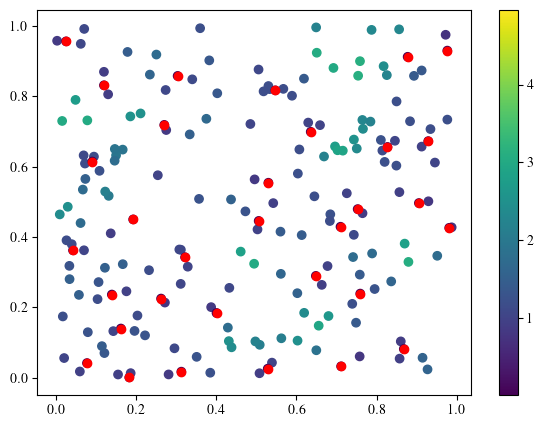

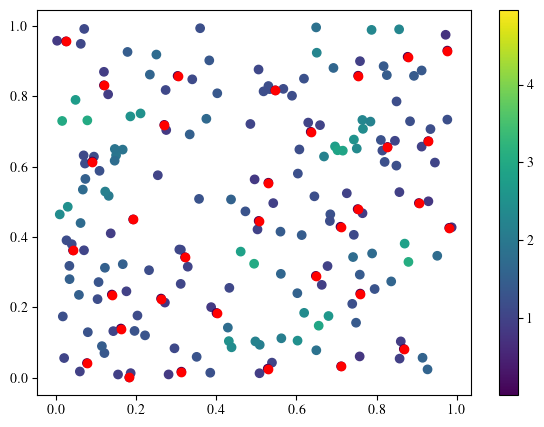

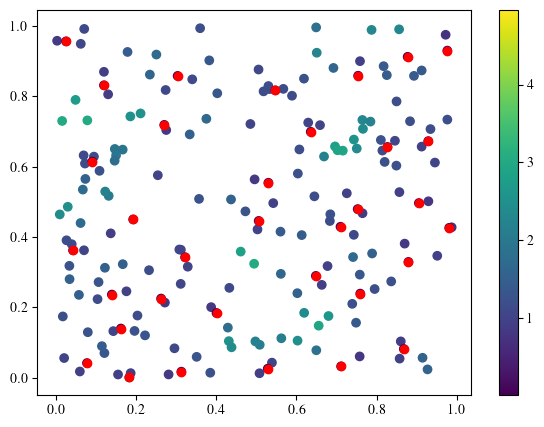

In [27]:
tau = eigvals[1]

for i in range(10):

    n_HF = len(inds_train)

    P_N = np.zeros((n_HF, n_LF))
    P_N[np.arange(n_HF), inds_train] = 1

    L_reg = np.linalg.matrix_power(L + tau * np.eye(n_LF), 2)

    B = 1 / (0.01 ** 2) * P_N.T @ P_N + 1. * L_reg
    C_phi = np.linalg.inv(B)
    dPhi = np.sqrt(np.diag(C_phi))

    if i  == 0:
        vmax = np.max(dPhi)

    fig, ax = plt.subplots(1, 1, figsize = (7, 5))
    ax1 = ax.scatter(X[:, 0], X[:, 1], c = dPhi, vmax=vmax, cmap = 'viridis')
    ax.scatter(X[inds_train, 0], X[inds_train, 1], c = 'r',)
    plt.colorbar(ax1)

    inds_train.append(np.argmax(dPhi))

#### Data loading

In [30]:
dataset_names =["darcy-flow", 
                "inclusion-field", 
                "inclusion-qoi",]

dataset_name = dataset_names[2]

x_LF, x_HF = load_data(
    dataset_name,
    preprocess=True,
    normalize=True, 
    flatten=True,
    )

x_LF, x_HF = x_LF[:2000], x_HF[:2000]
print(f"{x_LF.shape=}", f"{x_HF.shape=}")

Loading inclusion QoIs data ...
x_LF.shape=(2000, 5) x_HF.shape=(2000, 5)


### Plot data 

In [ ]:
plot_data(x_LF, x_HF, dataset_name, n_samples=3)

#### Multi-fidelity model

In [31]:
# Import model config fro dataset specified above
from specmf.common_config import MODEL_CONFIG
model_config = MODEL_CONFIG[dataset_name]["model_config"]
model_config

{'sigma': 0.01,
 'beta': 2,
 'kappa': 1e-10,
 'tau': 0.01,
 'method': 'full',
 'spectrum_cutoff': None}

In [32]:
# Define the graph configuration
graph_config = {
    'corr_scale': None,
    'metric': 'euclidean',
    'k_adj': 7,
    'p': 0.5,
    'q': 0.5,
}

# Create the graph 
g_LF = Graph(x_LF, **graph_config)

### Train the model with a single shot approach

In [34]:
n_HF_max = MODEL_CONFIG[dataset_name]["n_HF"]
n_HF_max = 60

In [35]:
# Create the model
model_single_shot = MultiFidelityModel(**model_config)

In [36]:
inds_train, labels = model_single_shot.cluster(g_LF, n_HF_max)

In [37]:
inds_val, inds_test = val_test_split(n_data=x_HF.shape[0], 
                                     inds_train=inds_train, 
                                     split_ratio=1.)

x_HF_train = x_HF[inds_train, :]
x_HF_val = x_HF[inds_val, :]
x_HF_test = x_HF[inds_test, :]

print(f"{x_HF_train.shape=}", f"{x_HF_val.shape=}", f"{x_HF_test.shape=}")

x_HF_train.shape=(60, 5) x_HF_val.shape=(1940, 5) x_HF_test.shape=(0, 5)


In [38]:
x_MF_single_shot, C_phi_single_shot, dPhi_single_shot = model_single_shot.fit(g_LF, x_HF_train, inds_train)

norm_C_phi_single_shot = np.linalg.norm(C_phi_single_shot)
norm_dPhi_single_shot = np.linalg.norm(dPhi_single_shot)

model_single_shot.summary()

Model Configuration:
sigma                   : 0.01
beta                    : 2
kappa                   : 1e-10
method                  : full
spectrum_cutoff         : None
tau                     : 0.01
n_clusters              : 60
model_optimized         : False
optimization_method     : None
_is_graph_clustered     : True
omega                   : 1e-06


In [39]:
# Error Analysis 
e_LF, e_MF_single_shot = error_analysis(x_LF, x_MF_single_shot, x_HF, return_values=True)

Mean relative l2 errors and Improvement Factor (IF)
----------------------------------------------------
Error LF:     80.2
Error MF:     21.51
IF:           3.729


### Train the model iteratively

In [40]:
total_HF = 5
n_increment = 1

model_iter = MultiFidelityModel(**model_config)
inds_train, labels = model_iter.cluster(g_LF, n=total_HF)
inds_train = inds_train.tolist()
x_HF_train = x_HF[inds_train, :]
x_MF_iter, C_phi_iter, dPhi_iter = model_iter.fit(g_LF, x_HF_train, inds_train)
g_LF.nodes = x_MF_iter
iterations = [total_HF]

norm_C_phi_iter = [np.linalg.norm(C_phi_iter)]
norm_dPhi_iter = [np.linalg.norm(dPhi_iter)]

while total_HF < n_HF_max:

    points_variance = np.sum(C_phi_iter, axis=1)
    ordered_inds = np.argsort(points_variance)[::-1]
    for ind in ordered_inds:
        if ind not in inds_train:
            inds_train.append(ind)
        if len(inds_train) == total_HF + n_increment:
            break
    total_HF += n_increment

    # model_iter = MultiFidelityModel(**model_config)
    x_HF_train = x_HF[inds_train, :]
    x_MF_iter, C_phi_iter, dPhi_iter = model_iter.fit(g_LF, x_HF_train, inds_train)
    # g_LF.nodes = x_MF_iter
    
    norm_C_phi_iter.append(np.linalg.norm(C_phi_iter))
    norm_dPhi_iter.append(np.linalg.norm(dPhi_iter))
    iterations.append(total_HF)
    print(f"Total HF: {total_HF}")
    
model_iter.summary()

Total HF: 6
Total HF: 7
Total HF: 8
Total HF: 9
Total HF: 10
Total HF: 11
Total HF: 12
Total HF: 13
Total HF: 14
Total HF: 15
Total HF: 16
Total HF: 17
Total HF: 18
Total HF: 19
Total HF: 20
Total HF: 21
Total HF: 22
Total HF: 23
Total HF: 24
Total HF: 25
Total HF: 26
Total HF: 27
Total HF: 28
Total HF: 29
Total HF: 30
Total HF: 31
Total HF: 32
Total HF: 33
Total HF: 34
Total HF: 35
Total HF: 36
Total HF: 37
Total HF: 38
Total HF: 39
Total HF: 40
Total HF: 41
Total HF: 42
Total HF: 43
Total HF: 44
Total HF: 45
Total HF: 46
Total HF: 47
Total HF: 48
Total HF: 49
Total HF: 50
Total HF: 51
Total HF: 52
Total HF: 53
Total HF: 54
Total HF: 55
Total HF: 56
Total HF: 57
Total HF: 58
Total HF: 59
Total HF: 60
Model Configuration:
sigma                   : 0.01
beta                    : 2
kappa                   : 1e-10
method                  : full
spectrum_cutoff         : None
tau                     : 0.01
n_clusters              : 5
model_optimized         : False
optimization_method     

In [41]:
# Error Analysis 
e_LF, e_MF_iter = error_analysis(x_LF, x_MF_iter, x_HF, return_values=True)

Mean relative l2 errors and Improvement Factor (IF)
----------------------------------------------------
Error LF:     80.2
Error MF:     21.36
IF:           3.755


### Compare variance and error of the models

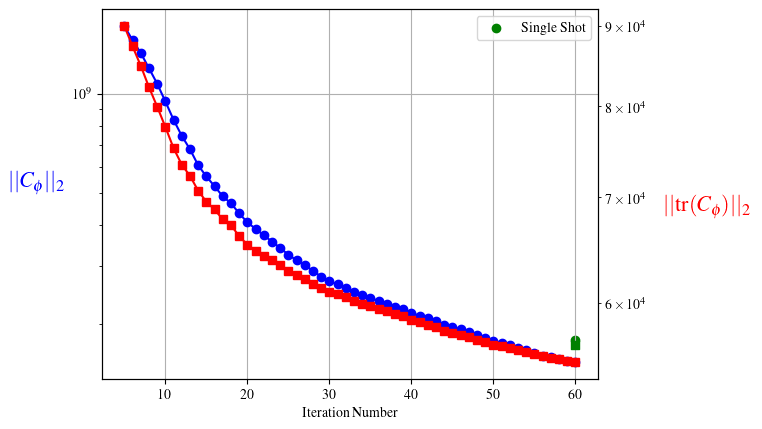

In [42]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(iterations, norm_C_phi_iter, color='blue', marker='o')
ax1.scatter(iterations[-1], norm_C_phi_single_shot, 
            color='green', marker='o',
            label='Single Shot')
ax1.set_xlabel('Iteration Number')
ax1.set_ylabel(r'$||C_{\phi}||_2$', 
               color='blue', 
               fontsize=16,
               labelpad=25,
               rotation=0)

ax2.plot(iterations, norm_dPhi_iter, color='red', marker='s')
ax2.scatter(iterations[-1], norm_dPhi_single_shot, 
            color='green', marker='s',
            label='Single Shot')
ax2.set_ylabel(r'$||\mathrm{tr}(C_{\phi})||_2$', 
               color='red',
               fontsize=16,
               labelpad=45,
               rotation=0)

ax1.legend(loc='upper right')
ax1.grid('on')
ax1.set_yscale('log')
ax2.set_yscale('log')
plt.show()